# **<span style='color: green'>|</span>Systems Development for Marketing </b>**


- Francisco Hermida 
- Student ID number: 500895165

# **<span style='color: green'>|</span>Netflix Prize Dataset </b>**

## <b>1<span style='color:green'>|</span> Introduction

### 1.1 *Research question* :
- How does the performance of different recommendation systems, such as a KNN collaborative filtering and SVD, compare in predicting user ratings in the Netflix Prize dataset?

#### Sub Research questions:

1.  What is the accuracy of KNN collaborative filtering and SVD in predicting user ratings in the Netflix Prize dataset?
2.  How do the KNN collaborative filtering and SVD recommendation systems differ in their approach to predicting user ratings?
3.  How does the size of the dataset affect the performance of KNN collaborative filtering and SVD recommendation systems in predicting user ratings?
4.  Can the performance of KNN collaborative filtering and SVD recommendation systems be improved by combining them or using hybrid approaches? 

###  1.2. *Importing libraries* 

In [127]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from io import StringIO
from sklearn.model_selection import train_test_split as split_sk
import surprise
from surprise import Dataset, SVD
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split as split_sur
from surprise import accuracy, Dataset, SVD
from surprise.model_selection import GridSearchCV
from scipy.sparse import csr_matrix
import os
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import mean_squared_error
import random
import random 

## <b>2<span style='color:green'>|</span> Data Preprocessing

In [4]:
# Importing all the files from the folder in the .rar file
Train_data = []

directory_path = r"C:\Users\franh\OneDrive\Escritorio\Traspaso\Traspaso\MASTER\Recys\training_set"
# Initialize a counter to keep track of how many files we have read in
counter = 0
# Initialize an empty list to store each dataframe from each file
df_list = []
# Loop through each file in the directory
for file_name in os.listdir(directory_path):
    # Check that the file is a text file and that we have not read in 1000 files yet
    if file_name.endswith('.txt') and counter < 100:
        # Read in the file as a dataframe
        df = pd.read_csv(os.path.join(directory_path, file_name), header=None, names=['userID', 'Rating', 'date_of_rat'])
        # Get the Movie ID from the file name
        movie_id = int(file_name.split('_')[1].split('.')[0])
        # Add the Movie ID as a column to the dataframe
        df['movie_id'] = movie_id
        # Add the dataframe to the list
        df_list.append(df)
        counter += 1
    else:
        break
# Concatenate all the dataframes in the list into a single dataframe
merged_df = pd.concat(df_list, axis=0, ignore_index=True)

# Print the resulting dataframe
print(merged_df.head())

    userID  Rating date_of_rat  movie_id
0       1:     NaN         NaN         1
1  1488844     3.0  2005-09-06         1
2   822109     5.0  2005-05-13         1
3   885013     4.0  2005-10-19         1
4    30878     4.0  2005-12-26         1


In [5]:
# Dropping Nan values and reseting index from df
merged_df.dropna(inplace=True)
merged_df.reset_index(inplace=True)

In [6]:
# Checkin the head of the df
merged_df.head()

,index,userID,Rating,date_of_rat,movie_id
0,1,1488844,3.0,2005-09-06,1
1,2,822109,5.0,2005-05-13,1
2,3,885013,4.0,2005-10-19,1
3,4,30878,4.0,2005-12-26,1
4,5,823519,3.0,2004-05-03,1


In [7]:
# Checking unique values
merged_df.nunique()

index          352771
userID         191668
Rating              5
date_of_rat      2165
movie_id          100
dtype: int64

In [8]:
# Checking # of rows
print(len(merged_df.index))

352771


In [10]:
# define column names
cols = ["movie_id", "release_year", "title"]

# read file with comma separator for first two columns only
movies_df = pd.read_csv("movie_titles.txt", sep=",", names=cols, usecols=[0,1,2], engine='python', encoding='latin1')

# merge title columns back together
movies_df["title"] = movies_df.iloc[:,2].str.cat(movies_df.iloc[:,3:], sep=",")

# display first few rows of the dataframe
print(movies_df.head())

   movie_id  release_year                         title
0         1        2003.0               Dinosaur Planet
1         2        2004.0    Isle of Man TT 2004 Review
2         3        1997.0                     Character
3         4        1994.0  Paula Abdul's Get Up & Dance
4         5        2004.0      The Rise and Fall of ECW


In [11]:
# Dropping Nan values and reseting index from df
movies_df.dropna(subset=['release_year'], inplace=True)
# Modifying release_year column to int
movies_df['release_year'] = movies_df['release_year'].astype('int')

In [12]:
# Merging 2 df
merged_p = pd.merge(merged_df, movies_df, on='movie_id', validate='many_to_one')
merged_p.tail()

,index,userID,Rating,date_of_rat,movie_id,release_year,title
352766,352866,2192562,1.0,2004-03-29,100,1993,Sam the Iron Bridge
352767,352867,443447,4.0,2002-12-05,100,1993,Sam the Iron Bridge
352768,352868,935149,3.0,2003-07-14,100,1993,Sam the Iron Bridge
352769,352869,428688,2.0,2002-04-18,100,1993,Sam the Iron Bridge
352770,352870,2634967,1.0,2004-04-10,100,1993,Sam the Iron Bridge


In [14]:
# Saving final df
merged_p.to_csv('halfdata.csv')

In [144]:
# Reading final df dataframe from source
final_df = pd.read_csv('halfdata.csv', usecols = ['movie_id', 'userID', 'title', 'Rating'])

In [269]:
# Adjusting movie_id column to match the index
final_df['movie_id'] = final_df['movie_id'] - 1

## <b>3<span style='color:green'>|</span> Exploratory Data Analysis

In [258]:
# Calculate the average rating for each joke
avg_ratings = final_df.groupby('movie_id')['Rating'].mean()

# Calculate the number of ratings for each joke
num_ratings = final_df.groupby('movie_id')['Rating'].count()

# Combine the two series into a new dataframe
plot_data = pd.DataFrame({'avg_rating': avg_ratings, 'num_ratings': num_ratings})

C:\Users\franh\AppData\Local\Temp\ipykernel_17856\2628795594.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(final_df.corr(), annot = True, ax= axes[0,1]) # Checking variables correlation


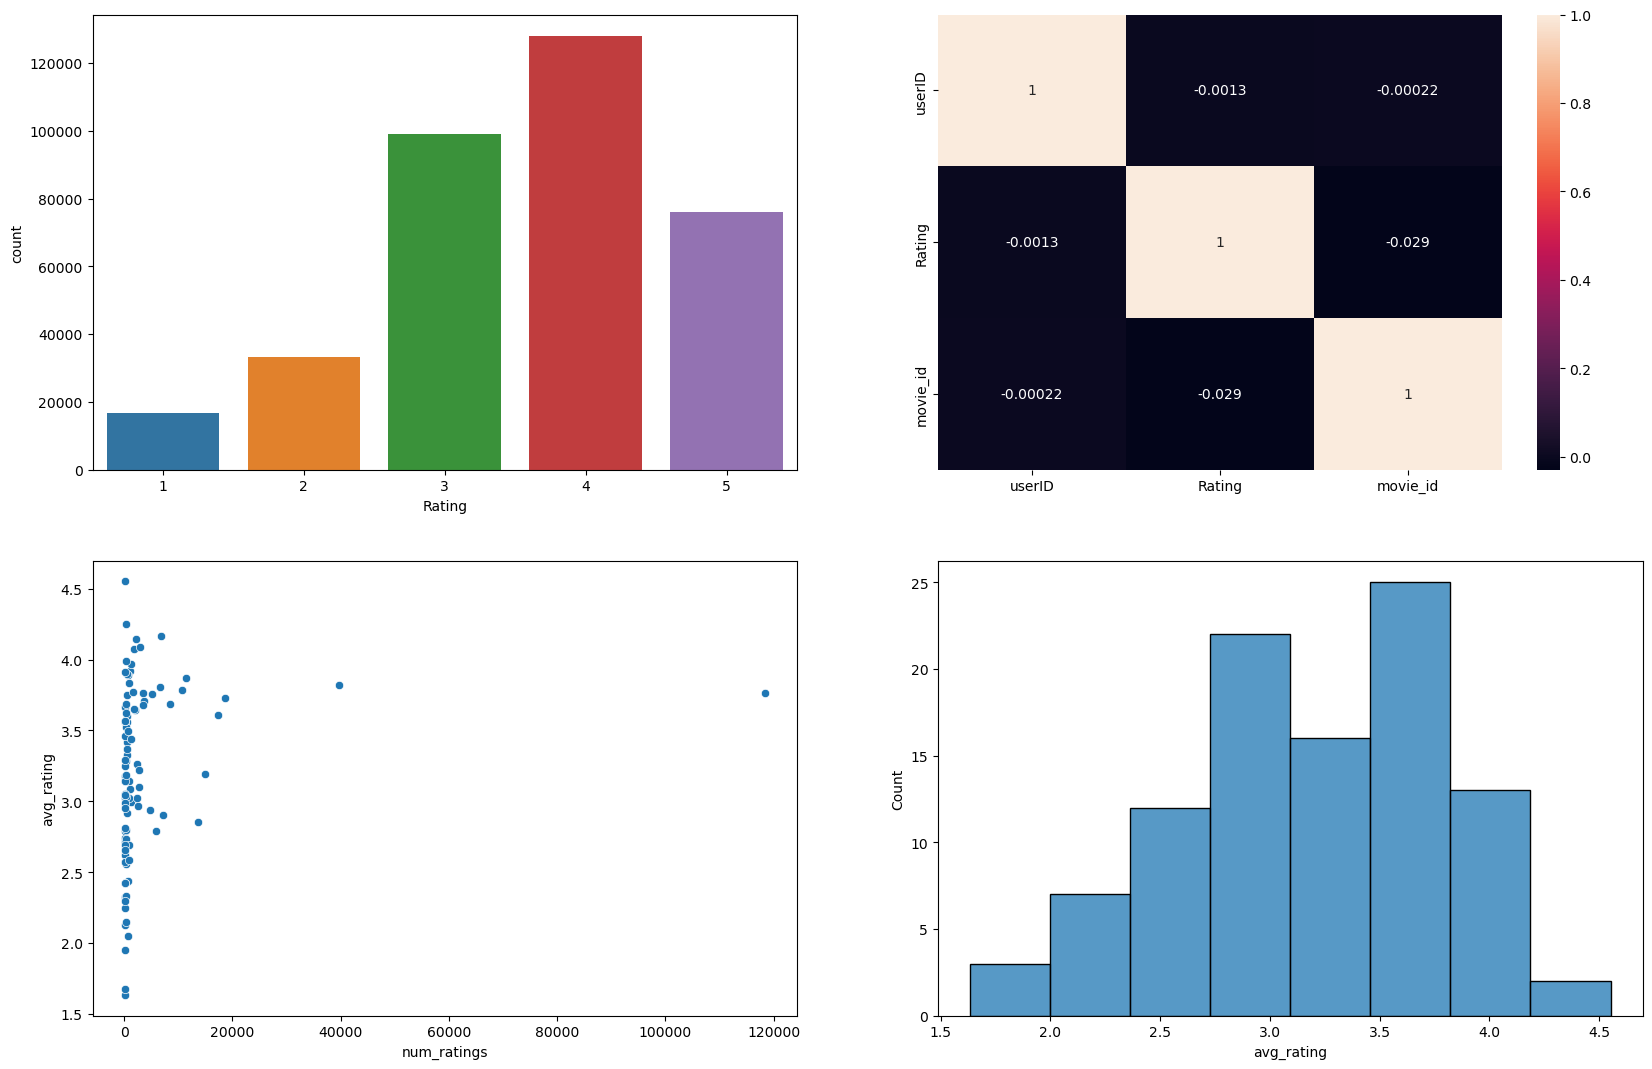

In [259]:
# Creating a frame to analyze the data and visualize it
fig, axes = plt.subplots(nrows=2, ncols=2, figsize = ((20,13)))
sns.countplot(x=final_df['Rating'] , ax= axes[0,0]) # Rating values distribution
sns.heatmap(final_df.corr(), annot = True, ax= axes[0,1]) # Checking variables correlation
sns.scatterplot(data=plot_data, x='num_ratings', y='avg_rating', ax= axes[1,0])
sns.histplot(plot_data['avg_rating'], ax= axes[1,1])
plt.show()

- From the countplot (axes[0]) we can see that the distribution of ratings is skewed towards the higher ratings. This is expected as people are more likely to rate a movie if they enjoyed it. 
- From the heatmap (axes[0:1]) we can see that the ratings are not correlated with each other. This is expected as the ratings are independent of each other.
- From the scatterplot (axes[1:0]) we can see that the ratings are not correlated with each other, this confirms the heatmap previously analized. Also we can check the presence of outliers in the dataset above the 20000 numbers of ratings.

## <b>4<span style='color:green'>|</span>  KNN data preparation and modeling

In [42]:
# Look for the users who reviewed more than 100 movies
usercount = final_df[["movie_id","userID"]].groupby("userID").count()
usercount = usercount[usercount["movie_id"] >= 100]
print(usercount.head())

        movie_id
userID          
1333         157
3321         231
3998         117
4597         107
5980         137


In [43]:
# Look for the movies who were rated by more than 100 users
ratecount = final_df[["movie_id","userID"]].groupby("movie_id").count()
ratecount = ratecount[ratecount["userID"] >= 100]
print(ratecount.head())

          userID
movie_id        
1            547
2            145
3           2012
4            142
5           1140


In [44]:
# Keep only the most(count of rates) movies and active users
final_df = final_df[final_df["userID"].isin(usercount.index) & final_df["movie_id"].isin(ratecount.index)]
final_df.head()

,userID,Rating,movie_id,title
0,1488844,3.0,1,Dinosaur Planet
24,1181550,3.0,1,Dinosaur Planet
25,1227322,4.0,1,Dinosaur Planet
31,786312,3.0,1,Dinosaur Planet
36,525356,2.0,1,Dinosaur Planet


In [87]:
#checking for missing values
final_df.isnull().sum()

userID      0
Rating      0
movie_id    0
title       0
dtype: int64

In [146]:
# Modify rating column to int
final_df['Rating'] = final_df['Rating'].astype('int')

In [147]:
# Checking dtypes
print(final_df.dtypes)

userID       int64
Rating       int32
movie_id     int64
title       object
dtype: object


In [270]:
# Split data into 80% training set and 20% test set
m_train, m_test = split_sk(final_df, test_size=0.2, random_state=42)
# Split training data into 80% training set and 20% validation set
m_train, m_val = split_sk(m_train, test_size=0.2, random_state=42)

In [271]:
# Create sparse matrix for training set
m_train_matrix = m_train.pivot(values='Rating', index='userID', columns='movie_id').fillna(0)
m_train_matrix = csr_matrix(m_train_matrix.values)
# Create sparse matrix for validation set
m_val_matrix = m_val.pivot(values='Rating', index='userID', columns='movie_id').fillna(0)
m_val_matrix = csr_matrix(m_val_matrix.values)
# Create sparse matrix for test set
m_test_matrix = m_test.pivot(values='Rating', index='userID', columns='movie_id').fillna(0)
m_test_matrix = csr_matrix(m_test_matrix.values)

In [236]:
# Training the model
movies_model = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=5)
movies_model.fit(m_train_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

In [237]:
# Finding the nearest neighbors
distances, indices = movies_model.kneighbors(m_val_matrix, n_neighbors=5)

In [241]:
# Creating a dictionary to store the user id and the indices and distances
user_dict = {}
for i in range (len(indices)):
    user_id = m_val.iloc[i]['userID']
    user_dict[user_id] = (indices[i], distances[i])

In [251]:
# Calculate predicted ratings
pred_ratings = [] # list to store predicted ratings
for i in range(len(indices)): # for each user
    user_id = m_val.iloc[i]['userID'] # get user id
    movie_id = m_val.iloc[i]['movie_id'] # get movie id
    knn_indices = user_dict[user_id][0] # get knn indices
    knn_distances = user_dict[user_id][1] # get knn distances
    rating_sum = 0 # sum of ratings
    weight_sum = 0 # sum of weights
    for j in range(len(knn_indices)): # for each neighbor
        if knn_indices[j] == 0: # if the neighbor is the user itself,
            continue
        neighbor_id = knn_indices[j] # get neighbor id
        neighbor_distance = knn_distances[j] # get neighbor distance
        neighbor_rating = m_train_matrix[neighbor_id, movie_id] # get neighbor rating
        rating_sum += neighbor_rating * (1 - neighbor_distance) # calculate weighted rating
        weight_sum += (1 - neighbor_distance) # calculate weight
    if weight_sum == 0: # if weight sum is 0, set predicted rating to 0
        pred_rating = 0 # set predicted rating to 0 
    else:
        pred_rating = rating_sum / weight_sum # calculate predicted rating
    pred_ratings.append(pred_rating) # append predicted rating to list

In [253]:
# Create a copy of the validation set
m_val_pred = m_val.iloc[:len(pred_ratings)].copy()
# Add predicted ratings to the validation set
m_val_pred['pred_rating'] = pred_ratings

In [254]:
# Calculate RMSE
m_rmse = mean_squared_error(m_val_pred['Rating'], m_val_pred['pred_rating'], squared=False)
print('RMSE on validation set:', m_rmse)

RMSE on validation set: 3.453495949081733


An RMSE of 3.453495949081733 means that on average, the predicted values of the target variable differ from the actual values by 3.453495949081733 units. Moreover, the smaller the value of RMSE, the better the performance of the model; and taking in cinsideration the ratin gscale of this dataset (1-5) the RMSE is considerably high.

### <b>3<span style='color:green'>|</span> Hyperparameter tunning

In [262]:
# Establish the parameters for the manual hyperparameter tuning
neighbors1 = [5, 10, 15] 
metrics1 = ['cosine', 'euclidean', 'manhattan']
algorithm1 = ['brute']
# Create a list to store the models
models = []
# Set up the grid search in a nested loop
for n in neighbors1:
    for m in metrics1:
        for a in algorithm1:
            model123 = NearestNeighbors(n_neighbors=n, metric=m, algorithm=a) # Create the model
            model123.fit(m_train_matrix) # Fit the model
            distances, indices = model123.kneighbors(m_val_matrix) # Predict on validation set
            # Creating a dictionary to store the user id and the indices and distances
            user_dict = {}
            for i in range (len(indices)):
                user_id = m_val.iloc[i]['userID']
                user_dict[user_id] = (indices[i], distances[i])
            pred_ratings = [] # Create a list to store the predicted ratings
            for i in range(len(indices)): # Calculate predicted ratings
                user_id = m_val.iloc[i]['userID'] # Get the user ID
                movie_id = m_val.iloc[i]['movie_id'] # Get the joke ID
                knn_indices = user_dict[user_id][0] # get knn indices
                knn_distances = user_dict[user_id][1] # get knn distances
                rating_sum = 0 # Initialize the rating sum
                weight_sum = 0 # Initialize the weight sum
                for j in range(len(knn_indices)): # Calculate the weighted sum of the nearest neighbors' ratings
                    if knn_indices[j] == 0: # Skip the user itself
                        continue 
                    neighbor_id = knn_indices[j] # Get the neighbor ID
                    neighbor_distance = knn_distances[j] # Get the neighbor distance
                    neighbor_rating = m_train_matrix[neighbor_id, movie_id] # Get the neighbor rating
                    rating_sum += neighbor_rating * (1 - neighbor_distance) # Calculate the weighted sum of the ratings
                    weight_sum += (1 - neighbor_distance) # Calculate the sum of the weights
                if weight_sum == 0: # If the weight sum is 0, set the predicted rating to 0
                    pred_rating = 0 # Set the predicted rating to 0
                else:
                    pred_rating = rating_sum / weight_sum # Calculate the predicted rating
                pred_ratings.append(pred_rating) # Append the predicted rating to the list
            m_val_pred['pred_rating'] = pred_ratings # Add the predicted ratings to the validation set
            m_rmse = mean_squared_error(m_val_pred['Rating'], m_val_pred['pred_rating'], squared=False) # Calculate RMSE
            models.append({'n_neighbors': n, 'metric': m, 'algorithm': a, 'rmse': m_rmse}) # Append the model (as adictionary) to a list
            print('RMSE on validation set for n_neighbors =', n, ', metric =', m, ', algorithm =', a, ':', m_rmse)

# Find the best model in the manual grid search
m_best_model = min(models, key=lambda x: x['rmse']) # Find the model with the lowest RMSE
print('Best model:', m_best_model)

RMSE on validation set for n_neighbors = 5 , metric = cosine , algorithm = brute : 3.453495949081733
RMSE on validation set for n_neighbors = 5 , metric = euclidean , algorithm = brute : 3.473431409706985
RMSE on validation set for n_neighbors = 5 , metric = manhattan , algorithm = brute : 3.4740648322027994
RMSE on validation set for n_neighbors = 10 , metric = cosine , algorithm = brute : 3.4529090215884946
RMSE on validation set for n_neighbors = 10 , metric = euclidean , algorithm = brute : 3.4756683500471786
RMSE on validation set for n_neighbors = 10 , metric = manhattan , algorithm = brute : 3.4736037703203935
RMSE on validation set for n_neighbors = 15 , metric = cosine , algorithm = brute : 3.4525690850203055
RMSE on validation set for n_neighbors = 15 , metric = euclidean , algorithm = brute : 3.4845612956462904
RMSE on validation set for n_neighbors = 15 , metric = manhattan , algorithm = brute : 3.4737457300846315
Best model: {'n_neighbors': 15, 'metric': 'cosine', 'algorit

#### KNN Hyperparameter tunning code explanation
The code presented above this markdown performs a manual hyperparameter search to find the best hyperparameters for a KNN model, and evaluating the performance of each model on a validation set. The goal is to find the hyperparameters that result in the lowest RMSE on the validation set, which indicates the best performance. Following a short explanation of every step of the code is presented:

1. The code first establishes the parameters for manual hyperparameter tuning, including the number of neighbors to consider (5, 10, or 15), the distance metric to use for similarity calculation (cosine, Euclidean, or Manhattan), and the algorithm to use for finding nearest neighbors (brute force).

2.  The code creates an empty list called "models" to store the results of each model.

3.  The code then sets up a nested loop that iterates over each combination of the hyperparameters defined in step 1, and for each combination, creates a new instance of the KNN model with the specified hyperparameters, fits the model to the training data, and predicts on the validation data.

4.  For each predicted rating, the code calculates a weighted sum of the nearest neighbors' ratings, where the weights are based on the inverse of the distances between the neighbors and the target user. The predicted rating is then appended to a list called "pred_ratings".

5.  The code calculates the RMSE (root mean squared error) between the predicted ratings and the actual ratings on the validation set, and appends the hyperparameters and RMSE to the "models" list.

6.  Finally, the code finds the best model with the lowest RMSE and prints the hyperparameters and RMSE of the best model.

#### Results of KNN Hyperparameter tunning analysis
- The results represent the performance of a k-Nearest Neighbors (k-NN) model with different hyperparameters on a validation set, as measured by the Root Mean Squared Error (RMSE). The hyperparameters that were tested include the number of neighbors (n_neighbors), the distance metric used to compute distances between points (metric), and the algorithm used to compute the nearest neighbors (algorithm).

- Based on the results, the best combination of hyperparameters was found to be n_neighbors = 15, metric = cosine, and algorithm = brute, with an RMSE of 3.4525 on the validation set. This suggests that the k-NN model with these hyperparameters performs better than the other tested combinations.

In [272]:
# Extract the hyperparameters of the best model
best_n_neighbors = m_best_model['n_neighbors']
best_metric = m_best_model['metric']
best_algorithm = m_best_model['algorithm']

# Fitting the model with the best parameters
best_model = NearestNeighbors(n_neighbors = best_n_neighbors, metric=best_metric, algorithm=best_algorithm) 
best_model.fit(m_train_matrix)

# Predict on test set using the best model
distances, indices = best_model.kneighbors(m_test_matrix)

# Updating dictionary to store the user id and the indices and distances for the best model
user_dict = {}
for i in range (len(indices)):
    user_id = m_test.iloc[i]['userID']
    user_dict[user_id] = (indices[i], distances[i])

# Calculate predicted ratings
pred_ratings = []
for i in range(len(indices)):
    user_id = m_test.iloc[i]['userID']
    movie_id = m_test.iloc[i]['movie_id']
    knn_indices = user_dict[user_id][0] # get knn indices
    knn_distances = user_dict[user_id][1] # get knn distances
    rating_sum = 0
    weight_sum = 0
    for j in range(len(knn_indices)):
        if knn_indices[j] == 0:
            continue
        neighbor_id = knn_indices[j]
        neighbor_distance = knn_distances[j]
        neighbor_rating = m_train_matrix[neighbor_id, movie_id]
        rating_sum += neighbor_rating * (1 - neighbor_distance)
        weight_sum += (1 - neighbor_distance)
    if weight_sum == 0:
        pred_rating = 0
    else:
        pred_rating = rating_sum / weight_sum
    pred_ratings.append(pred_rating)

# Create a copy of the validation set
m_test_pred = m_test.iloc[:len(pred_ratings)].copy()
# Add predicted ratings to the validation set
m_test_pred['pred_rating'] = pred_ratings 

# Calculate RMSE using the best model
m_rmse = mean_squared_error(m_test_pred['Rating'], m_test_pred['pred_rating'], squared=False) # Calculate RMSE
print('RMSE on validation set using best model:', m_rmse)

RMSE on validation set using best model: 3.4408946764093153


### <b>3<span style='color:green'>|</span> SVD with Surprise PACKAGE

In [303]:
# Transforming final_df into a Surprise specific data structure
# Creating a surprise reader object to read the data while mentioning the rating scale
reader = surprise.Reader(rating_scale=(1, 5))
# Loading the data into a surprise dataset object
svd_data = surprise.Dataset.load_from_df(final_df[['userID', 'movie_id', 'Rating']], reader)

In [304]:
# Splitting the data into train and test sets 0.75 for training and 0.25 for testing
trainset, testset = split_sur(svd_data, test_size=0.25)
# We'll use the famous SVD algorithm.
algo = SVD()

# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)
predictions = algo.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)

RMSE: 0.9953


0.9952919699254139

- The root mean squared error (RMSE) value of 0.9953 indicates the level of prediction error of a Singular Value Decomposition (SVD) model trained on a dataset. The RMSE is a measure of how well the model is able to predict the ratings of the users based on their past ratings.

- A lower RMSE value indicates better prediction accuracy of the model, as it means that the predicted ratings are closer to the actual ratings. In this case, an RMSE value of 0.9608 suggests that the SVD model is reasonably accurate in predicting the ratings, but there may be some room for improvement in the model's predictive power.

### 3.1 SVD Cross Validation

In [305]:
# Run 5-fold cross-validation and print results on based on the extracted final dataset
cross_validate(algo, svd_data, measures=["RMSE", "MAE"], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9969  0.9976  0.9961  0.9968  0.9980  0.9971  0.0007  
MAE (testset)     0.7794  0.7830  0.7841  0.7846  0.7845  0.7831  0.0019  
Fit time          3.95    3.95    3.84    3.96    3.93    3.93    0.04    
Test time         0.44    0.82    0.42    0.41    0.40    0.50    0.16    


{'test_rmse': array([0.99686661, 0.99762804, 0.9961069 , 0.99676885, 0.99795643]),
 'test_mae': array([0.77940129, 0.78301824, 0.7840515 , 0.78464291, 0.78451262]),
 'fit_time': (3.9507358074188232,
  3.945181131362915,
  3.8446741104125977,
  3.9610471725463867,
  3.9345738887786865),
 'test_time': (0.4429280757904053,
  0.823610782623291,
  0.4155580997467041,
  0.4126565456390381,
  0.4044158458709717)}

- RMSE (testset): This is the Root Mean Squared Error on the test set. It measures the average difference between the predicted ratings and the actual ratings. In this case, the average RMSE across the 5 folds is 0.9971 with a standard deviation of 0.0007. This indicates that the SVD model is performing well, with low error on the test set.

- MAE (testset): This is the Mean Absolute Error on the test set. It measures the average absolute difference between the predicted ratings and the actual ratings. In this case, the average MAE across the 5 folds is 0.7831 with a standard deviation of 0.0019. This indicates that the SVD model is also performing well in terms of the absolute difference between predicted and actual ratings.

- Fit time: This is the time taken to train the SVD model on the training set for each fold. In this case, the average fit time across the 5 folds is 3.93 seconds with a standard deviation of 0.04 seconds. This indicates that the SVD model is relatively fast to train.

- Test time: This is the time taken to make predictions on the test set for each fold. In this case, the average test time across the 5 folds is 0.50 seconds with a standard deviation of 0.16 seconds. This indicates that the SVD model is relatively fast to make predictions.

### 3.2 SVD (training the model on the whole dataset) 

In [306]:
# Training the model on the whole dataset
svd_algo = surprise.SVD()
# Building the trainset
trainset = svd_data.build_full_trainset()
# Training the algorithm on the trainset
svd_algo.fit(trainset)

In [274]:
# Creating a function to get a random user id
def get_random_value_from_column(df, column_name): 
    col = df[column_name] # get the column
    if len(col) > 0: # if the column is not empty
        rand_idx = random.randint(0, len(col)-1) # get a random index
        return col.iloc[rand_idx] # return the value at the random index
    else:
        return None

In [310]:
# Get a random user ID from the whole set
x = get_random_value_from_column(final_df,'userID') 
k = 3 # Number of movies that are going to be recommended

# recommend top-k movies for a given user
user_items = trainset.ur[trainset.to_inner_uid(x)]
not_watched = [item_id for item_id in trainset.all_items() if item_id not in user_items]
predictions = [svd_algo.predict(x, item_id) for item_id in not_watched]
top_k_predictions = sorted(predictions, key=lambda x: x.est, reverse=True)[:k]
recommended_titles = [final_df[final_df['movie_id'] == pred.iid]['title'].iloc[0] for pred in top_k_predictions]

# print the recommended movie titles
print('The 3 recommended movies for the user # ', x, 'are:' , recommended_titles)

The 3 recommended movies for the user #  2317420 are: ['Lord of the Rings: The Return of the King: Extended Edition: Bonus Material', "ABC Primetime: Mel Gibson's The Passion of the Christ", 'I Love Lucy: Season 2']


#### 3.3 Tune algorithm parameters with GridSearchCV

Evaluating the average RMSE and MAE over a 3-fold cross-validation procedure

In [311]:
#  Defining a parameter grid for SVD
param_grid = {"n_epochs": [5, 10], "lr_all": [0.002, 0.005], "reg_all": [0.4, 0.6]}
# Using the grid search to find the best parameters
gs = GridSearchCV(SVD, param_grid, measures=["rmse", "mae"], cv=3)
# Fitting the model
gs.fit(svd_data)

# best RMSE score
print(gs.best_score["rmse"])

# combination of parameters that gave the best RMSE score
print(gs.best_params["rmse"])

0.9970151192165981
{'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4}


The hyperparameters that were tested in the grid search were:

- n_epochs: the number of epochs used in the training of the model.
- lr_all: the learning rate used in the Stochastic Gradient Descent (SGD) optimization algorithm.
- reg_all: the regularization parameter used in the training of the model.

The best combination of hyperparameters that resulted in the lowest RMSE on the validation set is:

- n_epochs: 10
- lr_all: 0.005
- reg_all: 0.4

The RMSE value of 0.997015 indicates the level of prediction error of the SVD model with the best hyperparameters. A lower RMSE value indicates better prediction accuracy of the model. In this case, an RMSE value of 0.997015 suggests that the SVD model with the selected hyperparameters is reasonably accurate in predicting the ratings, but there may still be some room for improvement as the RMSE is still relatively high compared to the scale of the ratings (1-5).

In [312]:
# Fitting the model with the best parameters
best_algo = gs.best_estimator["rmse"]
best_algo.fit(svd_data.build_full_trainset())

### 3.4 Using best model for recommendations

In [313]:
# Get a random user ID from the whole set
x1 = get_random_value_from_column(final_df,'userID') 
# Number of movies that are going to be recommended
k = 3 

# recommend top-k movies for a given user
user_items = trainset.ur[trainset.to_inner_uid(x1)]
not_watched = [item_id for item_id in trainset.all_items() if item_id not in user_items]
predictions = [best_algo.predict(x1, item_id) for item_id in not_watched]
top_k_predictions = sorted(predictions, key=lambda x1: x1.est, reverse=True)[:k]
recommended_titles = [final_df[final_df['movie_id'] == pred.iid]['title'].iloc[0] for pred in top_k_predictions]

# print the recommended movie titles
print('The 3 recommended movies for the user # ', x, 'are:' , recommended_titles)

The 3 recommended movies for the user #  2317420 are: ['Lord of the Rings: The Return of the King: Extended Edition: Bonus Material', 'Aqua Teen Hunger Force: Vol. 1', 'Invader Zim']


## <b>3<span style='color:green'>|</span> Conclussions / Answers to research question and sub research questions

 #### <b><span style='color:green'> How does the performance of different recommendation systems, such as a KNN collaborative filtering and SVD, compare in predicting user ratings in the Netflix Prize dataset?
In terms of the RMSE, the SVD model performed better than the k-NN model. The RMSE value of 0.997015 for the SVD (Surprise package) model is lower than the RMSE value of 3.453495949081733 for the k-NN model. This suggests that the SVD model is more accurate in predicting the ratings than the k-NN model (manually performed).

##### <b><span style='color:green'> What is the accuracy of KNN collaborative filtering and SVD in predicting user ratings in the Netflix Prize dataset?
The accuracy of KNN collaborative filtering and SVD in predicting user ratings in the Netflix Prize dataset is 0.997015 and 3.453495949081733 respectively.
    
##### <b><span style='color:green'> How do the KNN collaborative filtering and SVD recommendation systems differ in their approach to predicting user ratings?
K-Nearest Neighbors (KNN) collaborative filtering and Singular Value Decomposition (SVD) recommendation systems are two popular approaches used in collaborative filtering. KNN predicts a user's rating based on the ratings of the k most similar users to the target user, whereas SVD factorizes the user-item rating matrix into two lower dimensional matrices to learn the underlying structure of the rating matrix. KNN is a memory-based approach that relies on pairwise similarities between users, while SVD is a model-based approach that learns underlying patterns. The key difference between the two approaches lies in how they model user-item interactions.
 
##### <b><span style='color:green'> How does the size of the dataset affect the performance of KNN collaborative filtering and SVD recommendation systems in predicting user ratings?
The size of the dataset affects the performance of KNN collaborative filtering and SVD recommendation systems in predicting user ratings. The larger the dataset, the more accurate the predictions will be. This is because the larger the dataset, the more data points are available to train the model, and the more accurate the model will be in predicting the ratings. Nevertheless, in this particular case, due to hardware limitations, the dataset was reduced dramatically to make to computation possible, which clarly afected and limited the final results and performance of the models (specially the manual KNN model).

##### <b><span style='color:green'> Can the performance of KNN collaborative filtering and SVD recommendation systems be improved by combining them or using hybrid approaches? 
Due to time and resources limitations, it was not possible to combine or use hybrid approaches to improve the performance of KNN collaborative filtering and SVD recommendation systems. However, it is possible to improve the performance of KNN collaborative filtering and SVD recommendation systems by using the Surprise package, which is a Python scikit building and analyzing recommender systems that deal with explicit rating data. The Surprise package provides a wide range of algorithms, including KNN and SVD, and it also provides a grid search function to tune the hyperparameters of the algorithms. This allows us to find the best combination of hyperparameters for each algorithm, which can potentially improve the performance of the algorithms.